In [1]:
!git clone https://github.com/openai/clip.git
    
!git clone https://github.com/CompVis/taming-transformers

Cloning into 'clip'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 164 (delta 31), reused 49 (delta 19), pack-reused 91
Receiving objects: 100% (164/164), 8.87 MiB | 1.61 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1061, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 1061 (delta 12), reused 228 (delta 7), pack-reused 810
Receiving objects: 100% (1061/1061), 350.33 MiB | 3.06 MiB/s, done.
Resolving deltas: 100% (221/221), done.
Updating files: 100% (510/510), done.


In [4]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip install einops

     |████████████████████████████████| 64 kB 376 kB/s eta 0:00:011
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41913 sha256=a73bd533ad8ea946fdd23eaf593e19eebf70b4abd4c81e84db87d1d2596a598e
  Stored in directory: /Users/kaanbursa/Library/Caches/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy


In [1]:
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf
import urllib.request
from clip import clip

import warnings
warnings.filterwarnings('ignore')



In [2]:
## Hellper functions

def show_from_tensor(tensor):
    img = tensor.clone()
    img = img.mul(255).byte()
    img = img.cpu().numpy().transpose((1,2,0))
    plt.figure(figsize=(10,7))
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    
def norm_data(data):
    return (data.clip(-1, 1)+1)/2#range between 0 and 1

### Parameters
learning_rate = 0.5
batch_size = 1
wd = .1
noise_factor = .1


total_iter = 100 # update later
im_shape = [225, 400, 3] # h, w, c
size1, size2, channel = im_shape



    
    

In [3]:
# Clip Model
clipmodel, _ = clip.load('ViT-B/32', jit = False)
clipmodel.eval()
print(clip.available_models())

print('Clip model visual input resolution: ', clipmodel.visual.input_resolution)

device = torch.device("cuda:0")
torch.cuda.empty_cache()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']
Clip model visual input resolution:  224


In [4]:
# Taming transformer

%cd taming-transformers/
!mkdir -p models/vqgan_imagenet_f16_16384/checkpoint
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoint')) == 0:
    print('downloading')
    urllib.request.urlretrieve('https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1',
                               'models/vqgan_imagenet_f16_16384/checkpoint/last.ckpt')
    urllib.request.urlretrieve('https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1',
                               'models/vqgan_imagenet_f16_16384/configs/model.yaml')
                               
    

/Users/kaanbursa/Desktop/AI/Torch/Clip/taming-transformers


In [5]:
from taming.models.vqgan import VQModel

def load_config(path, display = False):
    config_data = OmegaConf.load(path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config_data)))
    return config_data

def load_vqgan(config, checkpoint=None):
    model = VQModel(**config.model.params)
    if checkpoint is not None:
        state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
    return model.eval()

def generator(x):
    x = taming_model.post_quant_conv(x)
    x = taming_model.decoder(x) # transformer
    return x


taming_config = load_config('./models/vqgan_imagenet_f16_16384/configs/model.yaml', display=True)
taming_model = load_vqgan(taming_config, './models/vqgan_imagenet_f16_16384/checkpoint/last.ckpt')#.to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_start: 0
        disc_weight: 0.8
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    n_embed: 1024
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
from torch import nn
class Parameters(nn.Module):
    def __init__(self):
        super(Parameters, self).__init__()
        self.data = 0.5 * torch.randn(batch_size, 256, size1//16, size2//16)#.cuda() # tensor of random values 1 x 256 x 14 x 25
        self.data = nn.Parameter(torch.sin(self.data)) #positional
        
    def forward(self):
        return self.data
        
        
def init_params():
    params = Parameters()#.cuda()
    optimizer = torch.optim.AdamW([{'params':[params.data], 'lr':learning_rate}], weight_decay = wd)
    return params, optimizer
        

torch.Size([1, 256, 14, 25])
img dimension torch.Size([1, 3, 224, 400])


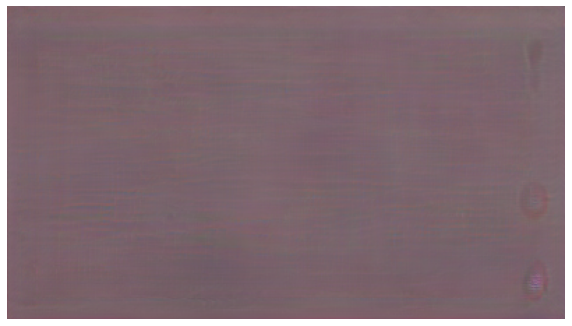

In [7]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def encode_text(text):
    t = clip.tokenize(text).cuda()
    t = clip.encode(t).detach().clone()
    return t

def create_encodings(include, exclude, extras):
    include_enc = []
    for text in include:
        t = encode_text(text)
        include_enc.append(t)
    exclude_enc = encode_text(exclude) if exclude is not '' else 0
    extras_enc = encode_text(extras) if extras is not '' else 0
    
    return include_enc, exlude_enc, extras_enc

augTransform = nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()
    
    
Params, optimizer = init_params()

with torch.no_grad():
    print(Params().shape)
    img = norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400
    print('img dimension', img.shape)
    show_from_tensor(img[0])
    
        

In [8]:
## Create crops
# Send numver of images to clip model to understand essence

def create_crops(image, num_crops=30):
    P = size1//2
    img = nn.functional.pad(img, (p, p, p, p), mode='constant', value=0) # 1 x 3 x 448 x 624 added 112*2 to all side
    
    img = augTransform(img)
    
    crop_set = []
    for i in range(num_crops):
        gap1 = int(torch.normal(1.0, 0.5, ()).clip(.2, 1.5) * size1)
        gap2 = int(torch.normal(1.0, 0.5, ()).clip(.2, 1.5) * size1)
        
        offsetx = torch.randint(0, int(size1*2-gap1), ())
        offsety = torch.randint(0, int(size1*2-gap1), ())
        
        crop = img[:,:, offsetx:offseetx+ gap2, offsety:offsety+gap2]
        
        crop = nn.functional.interpolate(crop, (224,224), mode='bilinear', align_corners=True)
        crop_set.append(crop)
    
    img_crops = torch.cat(crop_set, 0) # 30 x 3, 224, 224
    img_crops = img_crops + noise_factor * torch.randn_like(img_crops, required_grad=False)
    return img_crops



    



In [9]:
def showme(Params, show_crop):
    with torch.no_grad:
        generated = generator(Params())
        
        if show_crop:
            print('Augmented cropped example')
            aug_gen = generated.float()
            aug_gen = create_crops(aug_gen, num_crops=1)
            aug_gen_norm = norm_data(aug_gen[0])
            show_from_tensor(aug_gen_norm)
        
        print('Generation')
        latest_gen = norm_data(generated.cpu())
        show_from_tensor(latest_gen[0])
    return (latest_gen[0])
    

In [10]:
# Optimization process

def optimize_result(Params, prompt):
    alpha = 1 # importance of including encodings
    beta = 0.5 # imporatnce of excluding encodings
    
    out = generate(Params())
    out = norm_data(out)
    out = create_crops(out)
    
    out = normalize(out) # 30 x 3 x 224 x 224
    
    image_enc = clipmodel.encode_image(out) # 30 x 512
    
    
    #text encoding
    final_enc = w1*prompt + w2 * extras_enc # both has dimension of 1 x512
    final_text_include_enc = final_enc / final_enc.norm(dim=1, keepdim=1)
    final_text_exclude_enc = exclude_enc
    
    # Calculate loss
    main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1) # 30
    penalize_loss = torch.cosine_similarity(final_text_enclude_enc, image_enc, -1) # 30
    total_loss = alpha * main_loss + beta * penalize_loss
    return total_loss
    
    

def optimize(Params, optimizer, text_prompt):
    loss = optimize_result(Params, text_prompt).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    

In [11]:
def train_loop(Params, optimizer, shop_crop=False):
    res_img = []
    res_z = []
    
    for prompt in include_enc:
        iteration = 0
        Params, optimizer = init_params() # 1 x 256 x 14 x 25
        
        for it in range(total_iter):
            loss = optimize(Params, optimizer, prompt)
            
            if iteration >  0 and iteration % (total_iter-1) == 0:
                new_image = showme(Params, shop_crop)
                res_img.append(new_img)
                res_z.append(Params())
                print("loss: ", loss.item(), "\n iteration:", iteration)
                
            iteration += 1
        torch.cuda.empty_cache()
    return res_img, res_z

In [13]:
torch.cuda.empty_cache()
include = ['sketch of a lady', 'dancing lady in a ballroom']
exclude = 'cut, cropped, blurry, anime'
extras = "watercolor paper texture"
w1 = 1
w2 = 2
include_enc, exclude_enc, extras_enc = create_encodings(include, exclude, extras)
res_img, res_z = train_loop(Params, optimizer, show_crop=True)


AssertionError: Torch not compiled with CUDA enabled